# **Secondary Stock Data Preprocessing Notebook**
## In this notebook we will preprocess our secondary stock data, first creating our lag windows and the custom features that come from expanding the resulting view.  Then we will do any necessary cleaning such as reviewing outliers and missing values in our expanded data, imputing as needed so we have a clean dataset going into the next phase of the project.

#### Let's start by bringing in the libraries and logic necessary for reading in our file.

In [1]:

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats



#### Now let's read in our data that we need for this notebook.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'secondary_stocks_gen.csv')
sec_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
print(sec_stock_data.head())
print(sec_stock_data.shape)

           ticker  Close_sec  Volume_sec   Open_sec   High_sec    Low_sec  \
Date                                                                        
2019-01-02   BBWI  21.269199     6681903  20.282944  21.624899  20.194017   
2019-01-03   BBWI  21.390461     6329605  21.147940  21.875505  20.937754   
2019-01-04   BBWI  22.400970     7223090  21.665319  22.837509  21.665319   
2019-01-07   BBWI  23.338722     6760329  22.344381  24.001617  22.061440   
2019-01-08   BBWI  22.797091     6594076  23.508488  23.524656  21.988682   

              SMA_sec    EMA_sec    RSI_sec    BBM_sec  ...  CCI_20_sec  \
Date                                                    ...               
2019-01-02  21.912368  21.269199  53.374237  21.912368  ...   55.127041   
2019-01-03  21.912368  21.273955  53.374237  21.912368  ...   55.127041   
2019-01-04  21.912368  21.318151  53.374237  21.912368  ...   55.127041   
2019-01-07  21.912368  21.397389  53.374237  21.912368  ...   55.127041   
2019-01-08

#### The first step I want to undertake is handling and imputing any missing features.  I want to do this first so that when we create our lag windows and resulting custom features the new values will be calculated properly, and it will be easier to address our resulting outliers.  We will look at the same process that we used for our core stock data, a combination of ffill, bfill and linear interpolation for max efficiency of our missing values.

In [3]:
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

sec_stock_data = sec_stock_data.copy()

for col in sec_stock_data.columns:
    if sec_stock_data[col].isnull().any():
        sec_stock_data.loc[:, col] = fill_missing_vals(sec_stock_data[[col]])[col]



print(sec_stock_data.isna().sum())

ticker             0
Close_sec          0
Volume_sec         0
Open_sec           0
High_sec           0
Low_sec            0
SMA_sec            0
EMA_sec            0
RSI_sec            0
BBM_sec            0
BBU_sec            0
BBL_sec            0
MACD_sec           0
MACD_Signal_sec    0
MACD_Hist_sec      0
ADX_14_sec         0
CCI_20_sec         0
ATR_14_sec         0
Stoch_K_sec        0
Stoch_D_sec        0
Momentum_1_sec     0
Momentum_3_sec     0
Momentum_7_sec     0
Momentum_30_sec    0
Momentum_50_sec    0
OBV_sec            0
dtype: int64


C:\Users\ryanm\AppData\Local\Temp\ipykernel_39224\798176148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_39224\798176148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bfill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_39224\798176148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method = 'linear', inplace = True)
C:\

#### Looks great, now let's create the lag windows and custom features for our secondary stocks.

In [4]:
# We will need to create a temp variable since we are making so many custom features, it will otherwise create a PerformanceWarning since when we execute the cell on our main df its too much at once.
# By storing all the custom features to a temp variable and then concatenating them in a separate step it takes the pressure off in the execute phase.
new_temp_columns = pd.DataFrame(index = sec_stock_data.index)

# Now let's create a variable to house our features we want to create lag features for.
features_to_lag = ['Open_sec', 'High_sec', 'Low_sec', 'Volume_sec','Close_sec', 'EMA_sec', 'SMA_sec', 'RSI_sec', 'BBM_sec', 'BBL_sec', 'BBU_sec', 'MACD_sec', 'MACD_Signal_sec', 'MACD_Hist_sec', 'ADX_14_sec', 'CCI_20_sec', 'ATR_14_sec', 'Stoch_K_sec', 'Stoch_D_sec', 'Momentum_1_sec', 'Momentum_3_sec', 'Momentum_7_sec', 'Momentum_30_sec', 'Momentum_50_sec', 'OBV_sec']

# Now we apply the lag windows with a small 3-day window size.
for feature in features_to_lag:
    for lag in range(1,4):
        new_temp_columns[f'{feature}_Lag_{lag}'] = sec_stock_data[feature].shift(lag)

# Great, now from these new lag-based features let's expand on it further by creating some custom features using our existing ones.
new_temp_columns['Close_Lag_Avg_1_3_sec'] = new_temp_columns[['Close_sec_Lag_1', 'Close_sec_Lag_2', 'Close_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Close_Lag_Std_1_3_sec'] = new_temp_columns[['Close_sec_Lag_1', 'Close_sec_Lag_2', 'Close_sec_Lag_3']].std(axis = 1)

new_temp_columns['Open_Lag_Avg_1_3_sec'] = new_temp_columns[['Open_sec_Lag_1', 'Open_sec_Lag_2', 'Open_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Open_Lag_Std_1_3_sec'] = new_temp_columns[['Open_sec_Lag_1', 'Open_sec_Lag_2', 'Open_sec_Lag_3']].std(axis = 1)

new_temp_columns['High_Lag_Avg_1_3_sec'] = new_temp_columns[['High_sec_Lag_1', 'High_sec_Lag_2', 'High_sec_Lag_3']].mean(axis = 1)
new_temp_columns['High_Lag_Std_1_3_sec'] = new_temp_columns[['High_sec_Lag_1', 'High_sec_Lag_2', 'High_sec_Lag_3']].std(axis = 1)

new_temp_columns['Low_Lag_Avg_1_3_sec'] = new_temp_columns[['Low_sec_Lag_1', 'Low_sec_Lag_2', 'Low_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Low_Lag_Std_1_3_sec'] = new_temp_columns[['Low_sec_Lag_1', 'Low_sec_Lag_2', 'Low_sec_Lag_3']].std(axis = 1)

new_temp_columns['Volume_Lag_Avg_1_3_sec'] = new_temp_columns[['Volume_sec_Lag_1', 'Volume_sec_Lag_2', 'Volume_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Volume_Lag_Std_1_3_sec'] = new_temp_columns[['Volume_sec_Lag_1', 'Volume_sec_Lag_2', 'Volume_sec_Lag_3']].std(axis = 1)

new_temp_columns['EMA_Lag_Avg_1_3_sec'] = new_temp_columns[['EMA_sec_Lag_1', 'EMA_sec_Lag_2', 'EMA_sec_Lag_3']].mean(axis = 1)
new_temp_columns['EMA_Lag_Std_1_3_sec'] = new_temp_columns[['EMA_sec_Lag_1', 'EMA_sec_Lag_2', 'EMA_sec_Lag_3']].std(axis = 1)

new_temp_columns['SMA_Lag_Avg_1_3_sec'] = new_temp_columns[['SMA_sec_Lag_1', 'SMA_sec_Lag_2', 'SMA_sec_Lag_3']].mean(axis = 1)
new_temp_columns['SMA_Lag_Std_1_3_sec'] = new_temp_columns[['SMA_sec_Lag_1', 'SMA_sec_Lag_2', 'SMA_sec_Lag_3']].std(axis = 1)

new_temp_columns['RSI_Lag_Avg_1_3_sec'] = new_temp_columns[['RSI_sec_Lag_1', 'RSI_sec_Lag_2', 'RSI_sec_Lag_3']].mean(axis = 1)
new_temp_columns['RSI_Lag_Std_1_3_sec'] = new_temp_columns[['RSI_sec_Lag_1', 'RSI_sec_Lag_2', 'RSI_sec_Lag_3']].std(axis = 1)

new_temp_columns['BBM_Lag_Avg_1_3_sec'] = new_temp_columns[['BBM_sec_Lag_1', 'BBM_sec_Lag_2', 'BBM_sec_Lag_3']].mean(axis = 1)
new_temp_columns['BBM_Lag_Std_1_3_sec'] = new_temp_columns[['BBM_sec_Lag_1', 'BBM_sec_Lag_2', 'BBM_sec_Lag_3']].std(axis = 1)

new_temp_columns['BBU_Lag_Avg_1_3_sec'] = new_temp_columns[['BBU_sec_Lag_1', 'BBU_sec_Lag_2', 'BBU_sec_Lag_3']].mean(axis = 1)
new_temp_columns['BBU_Lag_Std_1_3_sec'] = new_temp_columns[['BBU_sec_Lag_1', 'BBU_sec_Lag_2', 'BBU_sec_Lag_3']].std(axis = 1)

new_temp_columns['BBL_Lag_Avg_1_3_sec'] = new_temp_columns[['BBL_sec_Lag_1', 'BBL_sec_Lag_2', 'BBL_sec_Lag_3']].mean(axis = 1)
new_temp_columns['BBL_Lag_Std_1_3_sec'] = new_temp_columns[['BBL_sec_Lag_1', 'BBL_sec_Lag_2', 'BBL_sec_Lag_3']].std(axis = 1)

new_temp_columns['Stoch_K_Lag_Avg_1_3_sec'] = new_temp_columns[['Stoch_K_sec_Lag_1', 'Stoch_K_sec_Lag_2', 'Stoch_K_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Stoch_K_Lag_Std_1_3_sec'] = new_temp_columns[['Stoch_K_sec_Lag_1', 'Stoch_K_sec_Lag_2', 'Stoch_K_sec_Lag_3']].std(axis = 1)

new_temp_columns['Stoch_D_Lag_Avg_1_3_sec'] = new_temp_columns[['Stoch_D_sec_Lag_1', 'Stoch_D_sec_Lag_2', 'Stoch_D_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Stoch_D_Lag_Std_1_3_sec'] = new_temp_columns[['Stoch_D_sec_Lag_1', 'Stoch_D_sec_Lag_2', 'Stoch_D_sec_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Lag_Avg_1_3_sec'] = new_temp_columns[['MACD_sec_Lag_1', 'MACD_sec_Lag_2', 'MACD_sec_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Lag_Std_1_3_sec'] = new_temp_columns[['MACD_sec_Lag_1', 'MACD_sec_Lag_2', 'MACD_sec_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Signal_Lag_Avg_1_3_sec'] = new_temp_columns[['MACD_Signal_sec_Lag_1', 'MACD_Signal_sec_Lag_2', 'MACD_Signal_sec_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Signal_Lag_Std_1_3_sec'] = new_temp_columns[['MACD_Signal_sec_Lag_1', 'MACD_Signal_sec_Lag_2', 'MACD_Signal_sec_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Hist_Avg_1_3_sec'] = new_temp_columns[['MACD_Hist_sec_Lag_1', 'MACD_Hist_sec_Lag_2', 'MACD_Hist_sec_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Hist_Lag_Std_1_3_sec'] = new_temp_columns[['MACD_Hist_sec_Lag_1', 'MACD_Hist_sec_Lag_2', 'MACD_Hist_sec_Lag_3']].std(axis = 1)

new_temp_columns['ADX_14_Lag_Avg_1_3_sec'] = new_temp_columns[['ADX_14_sec_Lag_1', 'ADX_14_sec_Lag_2', 'ADX_14_sec_Lag_3']].mean(axis = 1)
new_temp_columns['ADX_14_Lag_Std_1_3_sec'] = new_temp_columns[['ADX_14_sec_Lag_1', 'ADX_14_sec_Lag_2', 'ADX_14_sec_Lag_3']].std(axis = 1)

new_temp_columns['CCI_20_Lag_Avg_1_3_sec'] = new_temp_columns[['CCI_20_sec_Lag_1', 'CCI_20_sec_Lag_2', 'CCI_20_sec_Lag_3']].mean(axis = 1)
new_temp_columns['CCI_20_Lag_Std_1_3_sec'] = new_temp_columns[['CCI_20_sec_Lag_1', 'CCI_20_sec_Lag_2', 'CCI_20_sec_Lag_3']].std(axis = 1)

new_temp_columns['ATR_14_Lag_Avg_1_3_sec'] = new_temp_columns[['ATR_14_sec_Lag_1', 'ATR_14_sec_Lag_2', 'ATR_14_sec_Lag_3']].mean(axis = 1)
new_temp_columns['ATR_14_Lag_Std_1_3_sec'] = new_temp_columns[['ATR_14_sec_Lag_1', 'ATR_14_sec_Lag_2', 'ATR_14_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_1_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_1_sec_Lag_1', 'Momentum_1_sec_Lag_2', 'Momentum_1_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_1_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_1_sec_Lag_1', 'Momentum_1_sec_Lag_2', 'Momentum_1_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_3_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_3_sec_Lag_1', 'Momentum_3_sec_Lag_2', 'Momentum_3_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_3_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_3_sec_Lag_1', 'Momentum_3_sec_Lag_2', 'Momentum_3_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_7_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_7_sec_Lag_1', 'Momentum_7_sec_Lag_2', 'Momentum_7_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_7_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_7_sec_Lag_1', 'Momentum_7_sec_Lag_2', 'Momentum_7_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_30_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_30_sec_Lag_1', 'Momentum_30_sec_Lag_2', 'Momentum_30_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_30_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_30_sec_Lag_1', 'Momentum_30_sec_Lag_2', 'Momentum_30_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_50_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_50_sec_Lag_1', 'Momentum_50_sec_Lag_2', 'Momentum_50_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_50_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_50_sec_Lag_1', 'Momentum_50_sec_Lag_2', 'Momentum_50_sec_Lag_3']].std(axis = 1)

new_temp_columns['OBV_Lag_Avg_1_3_sec'] = new_temp_columns[['OBV_sec_Lag_1', 'OBV_sec_Lag_2', 'OBV_sec_Lag_3']].mean(axis = 1)
new_temp_columns['OBV_Lag_Std_1_3_sec'] = new_temp_columns[['OBV_sec_Lag_1', 'OBV_sec_Lag_2', 'OBV_sec_Lag_3']].std(axis = 1)

new_temp_columns['Close_Lag_Avg_1_3_sec'] = new_temp_columns[['Close_sec_Lag_1', 'Close_sec_Lag_2', 'Close_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Close_Lag_Std_1_3_sec'] = new_temp_columns[['Close_sec_Lag_1', 'Close_sec_Lag_2', 'Close_sec_Lag_3']].std(axis = 1)

new_temp_columns['Diff_Close_EMA_sec'] = sec_stock_data['Close_sec'] - sec_stock_data['EMA_sec']
new_temp_columns['Ratio_Close_EMA_sec'] = sec_stock_data['Close_sec'] / sec_stock_data['EMA_sec']

# Now we can concatenate onto our original core_stock_data.
sec_stock_data = pd.concat([sec_stock_data, new_temp_columns], axis = 1)

print(sec_stock_data.head())

#print(core_stock_data.head(10))
print(sec_stock_data.isnull().sum())

C:\Users\ryanm\AppData\Local\Temp\ipykernel_39224\3132855747.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_temp_columns['Stoch_D_Lag_Std_1_3_sec'] = new_temp_columns[['Stoch_D_sec_Lag_1', 'Stoch_D_sec_Lag_2', 'Stoch_D_sec_Lag_3']].std(axis = 1)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_39224\3132855747.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_temp_columns['MACD_Lag_Avg_1_3_sec'] = new_temp_columns[['MACD_sec_Lag_1', 'MACD_sec_Lag_2', 'MACD_sec_Lag_3']].mean(axis = 1)
C:\Users\ryanm\AppData\Local\Temp

           ticker  Close_sec  Volume_sec   Open_sec   High_sec    Low_sec  \
Date                                                                        
2019-01-02   BBWI  21.269199     6681903  20.282944  21.624899  20.194017   
2019-01-03   BBWI  21.390461     6329605  21.147940  21.875505  20.937754   
2019-01-04   BBWI  22.400970     7223090  21.665319  22.837509  21.665319   
2019-01-07   BBWI  23.338722     6760329  22.344381  24.001617  22.061440   
2019-01-08   BBWI  22.797091     6594076  23.508488  23.524656  21.988682   

              SMA_sec    EMA_sec    RSI_sec    BBM_sec  ...  \
Date                                                    ...   
2019-01-02  21.912368  21.269199  53.374237  21.912368  ...   
2019-01-03  21.912368  21.273955  53.374237  21.912368  ...   
2019-01-04  21.912368  21.318151  53.374237  21.912368  ...   
2019-01-07  21.912368  21.397389  53.374237  21.912368  ...   
2019-01-08  21.912368  21.452280  53.374237  21.912368  ...   

            Moment

#### It looks like through the creation of all of our new features there are just a few missing values that slipped through.  Let's re-run our imputation logic to take care of them.

In [5]:
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

sec_stock_data = sec_stock_data.copy()

for col in sec_stock_data.columns:
    if sec_stock_data[col].isnull().any():
        sec_stock_data.loc[:, col] = fill_missing_vals(sec_stock_data[[col]]).squeeze()



print(sec_stock_data.isna().sum())

C:\Users\ryanm\AppData\Local\Temp\ipykernel_39224\1745833017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_39224\1745833017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bfill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_39224\1745833017.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method = 'linear', inplace = True)


ticker                         0
Close_sec                      0
Volume_sec                     0
Open_sec                       0
High_sec                       0
                              ..
Momentum_50_Lag_Std_1_3_sec    0
OBV_Lag_Avg_1_3_sec            0
OBV_Lag_Std_1_3_sec            0
Diff_Close_EMA_sec             0
Ratio_Close_EMA_sec            0
Length: 153, dtype: int64


#### Great, now let's look into viewing and handling outliers.  We will first see the appearance of outliers using z_score with a standard std of 3, and then looking at the column feature spread.

In [6]:
numeric_cols = sec_stock_data.select_dtypes(include = [np.number])
z_scores = np.abs(stats.zscore(numeric_cols))
threshold = 3 # Common threshold starting std modifier

outliers = (z_scores > threshold)

print(outliers.sum(axis = 0))


Close_sec                      3400
Volume_sec                     5862
Open_sec                       3397
High_sec                       3400
Low_sec                        3393
                               ... 
Momentum_50_Lag_Std_1_3_sec    3273
OBV_Lag_Avg_1_3_sec            7444
OBV_Lag_Std_1_3_sec            2804
Diff_Close_EMA_sec             3593
Ratio_Close_EMA_sec            3889
Length: 152, dtype: int64


#### Yes that is quite a few of outliers, but remember we have 200 different stocks representing 5 years of historical data in this dataframe.  Currently there is 276350 rows, so the existing amount of shown outliers represent a very small percentage and we will continue to work on them as we go forward.

#### Our Volume_sec feature in particular has an alarming amount of outliers, and as we know Volume is used to calculate a lot of our other other custom features.  We will need to normalize the Volume feature so we can figure out what's going on.  Let's take a closer look with a plot.

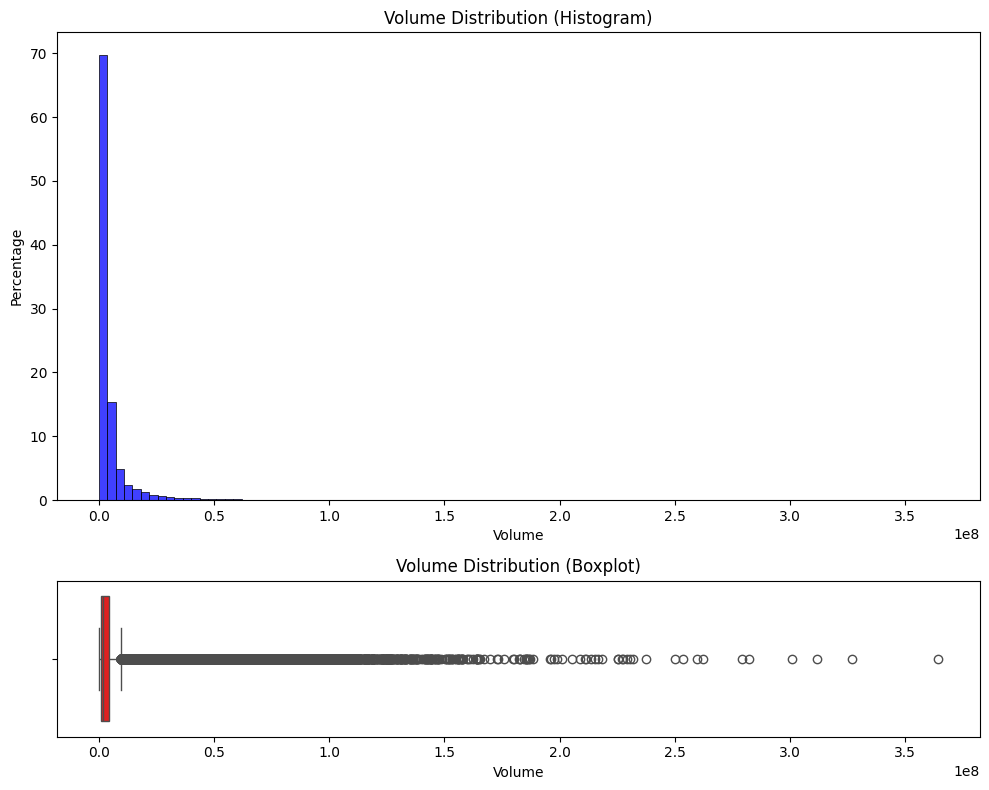

In [7]:
fig, ax = plt.subplots(2,1, figsize = (10, 8), gridspec_kw = {'height_ratios' : [3,1]})

sns.histplot(sec_stock_data['Volume_sec'], bins = 100, kde = False, ax = ax[0], stat = 'percent', color = 'b')
ax[0].set_title('Volume Distribution (Histogram)')
ax[0].set_xlabel('Volume')
ax[0].set_ylabel('Percentage')

sns.boxplot(x = sec_stock_data['Volume_sec'], ax = ax[1], color = 'r', whis = 1.5)
ax[1].set_title('Volume Distribution (Boxplot)')
ax[1].set_xlabel('Volume')


plt.tight_layout()
plt.show()

#### So the plot above tells us a few things about our Volume data.  It shows in the top portion that 70% of the Volume values have a very low trading volume.  As you move forward past that point the trading volumes increase but so do the number of observations for those points.  The boxplot below echoes this as well.  What this represents is that the large outliers (the smaller bars in the histogram that make up our outlier volume) could represent significant events or suddent spikes in activity.  As such further performance on our outliers is warranted so we can establish normal distribution.

In [8]:
def volume_log_transform(sec_stock_data):
    sec_stock_data['Volume_sec'] = np.log1p(sec_stock_data['Volume_sec'])
    return sec_stock_data

sec_stock_data = volume_log_transform(sec_stock_data)



#### Now we will replot the Volume feature to see how it looks after the log transform.

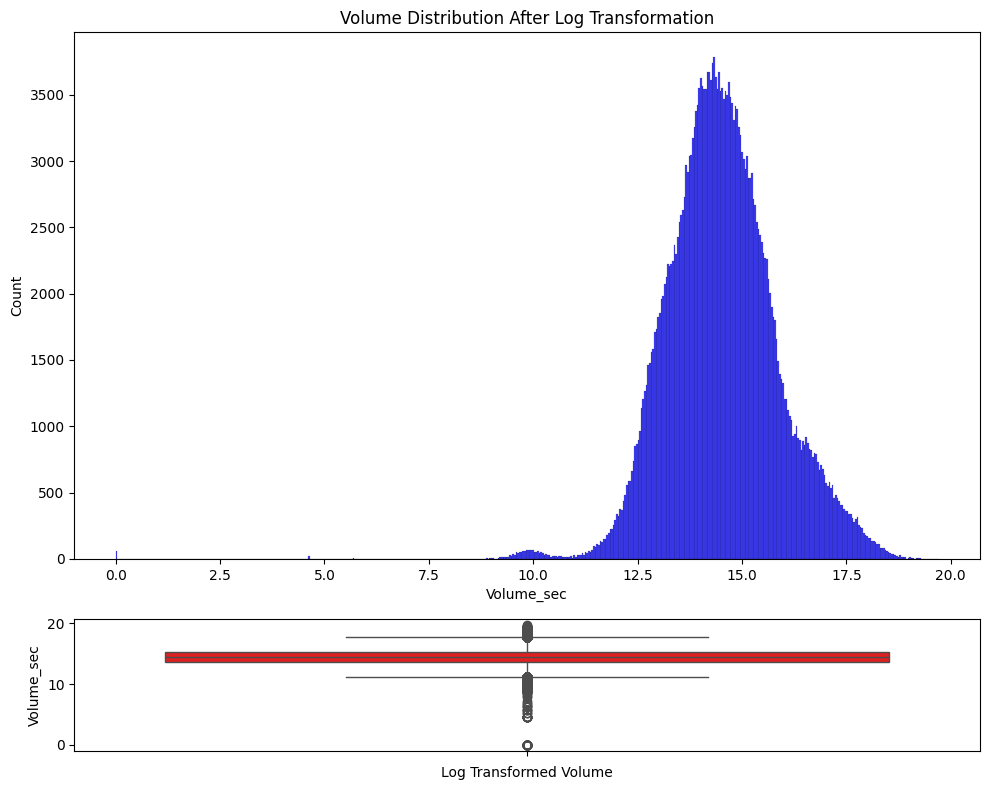

In [9]:
fig, (ax_hist, ax_box) = plt.subplots(
    2,
    figsize = (10,8),
    gridspec_kw = {'height_ratios' : [4,1]},
    )

sns.histplot(sec_stock_data['Volume_sec'], bins = 500, ax = ax_hist, color = 'blue')
ax_hist.set_title('Volume Distribution After Log Transformation')
ax_hist.set_ylabel('Count')

sns.boxplot(sec_stock_data['Volume_sec'], ax = ax_box, color = 'red')
ax_box.set_xlabel('Log Transformed Volume')

plt.tight_layout()
plt.show()


#### This is much better, there are noticeably fewer outliers shown in the top part of the plot and you can see the bell curve shape for our Volume feature.

#### Let's now apply this method to all of our numeric columns, also applying z_scores as well after the log transform.  We will then view each feature's respective outlier count from the log transform.

In [10]:
# We will be inserting logic to replace any 0 digits in our data with an extremely small number, the log transform doesn't work well with 0s or negative numbers.
def log_transform_and_zscore(dataframe):
    # Select all of our columns except Volume_sec since we have already performed outlier detection on it.
    numeric_cols = dataframe.select_dtypes(include = [np.number]).drop(columns = ['Volume_sec'], errors = 'ignore')
    
    # Replace any 0 values with extremely small integer.
    numeric_cols = numeric_cols.apply(lambda x : np.where(x <= 0, 1e-10, x))
    
    # Apply the log transform.
    log_transformed_data = np.log1p(numeric_cols)
    
    # Perform the Z-score calculation.
    z_scores = np.abs(stats.zscore(log_transformed_data))
    
    threshold = 3    
    outliers = (z_scores >= threshold)    
    outliers_summary = outliers.sum(axis = 0)
    
    # Filter out the outliers, maintaining the index, and maintaining the original dataframe.
    filtered_index = (~outliers).all(axis = 1)
    filtered_data = log_transformed_data[filtered_index].copy()
    
    print("Filtered data shape (excluding Volume_sec):", filtered_data.shape)
    
    # Reset index on both filtered_data and Volume_sec, then concat.
    if 'Volume_sec' in dataframe.columns:
        volume_sec = dataframe.loc[filtered_index, 'Volume_sec']
        print("Volume_sec shape before concatenation:", volume_sec.shape)
        
        filtered_data = pd.concat([filtered_data.reset_index(drop = True), volume_sec.reset_index(drop = True)], axis = 1)
        print("Filtered data shape after adding Volume_sec:", filtered_data.shape)

    return filtered_data, outliers_summary

transformed_data, outliers_summary = log_transform_and_zscore(sec_stock_data)

print(outliers_summary)

# our output below shows the TOTAL number of outliers for our 200 generated secondary stocks, and the different shape outputs verify that Volume_sec has been indeed added back in.




Filtered data shape (excluding Volume_sec): (221335, 151)
Volume_sec shape before concatenation: (221335,)
Filtered data shape after adding Volume_sec: (221335, 152)
Close_sec                      2007
Open_sec                       2005
High_sec                       2014
Low_sec                        2003
SMA_sec                        2027
                               ... 
Momentum_50_Lag_Std_1_3_sec    3259
OBV_Lag_Avg_1_3_sec               0
OBV_Lag_Std_1_3_sec            1894
Diff_Close_EMA_sec             1624
Ratio_Close_EMA_sec            3925
Length: 151, dtype: int64


#### Much better progress, our features have reduced their total of outliers and as we have seen from our work with the Volume_sec features using a log_transform will normalize the distribution, so it was performed on the rest of the data.  The only downside is that outliers were actually found in several new features.  This is something that is plausible when the log transform is performed and the data is 'spread out', the outliers that weren't apparent before now are reported.  Since the outlier value quantity is extremely low though at this point and everything else looks fine we will move forward at this time.

# For the last phase of our preprocessing notebook we can now move on to scaling our dataframe.

In [11]:
# We will need to temporarily drop the Ticker column as it is a float value.  We will create a variable for it now, and use it later to bring it back when needed.
tickers = sec_stock_data['ticker'].values
sec_stock_data = sec_stock_data.drop(columns = ['ticker'])

# Initiate the scaler and transform the data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sec_stock_data)
sec_stock_scaled = pd.DataFrame(scaled_data, index = sec_stock_data.index, columns = sec_stock_data.columns)

sec_stock_scaled['ticker'] = tickers
print(sec_stock_scaled.head())

            Close_sec  Volume_sec  Open_sec  High_sec   Low_sec   SMA_sec  \
Date                                                                        
2019-01-02  -0.433248    0.906503 -0.435677 -0.433313 -0.434749 -0.434888   
2019-01-03  -0.432960    0.865254 -0.433622 -0.432726 -0.432960 -0.434888   
2019-01-04  -0.430560    0.965813 -0.432392 -0.430469 -0.431211 -0.434888   
2019-01-07  -0.428333    0.915390 -0.430779 -0.427738 -0.430258 -0.434888   
2019-01-08  -0.429619    0.896427 -0.428013 -0.428857 -0.430433 -0.434888   

             EMA_sec   RSI_sec   BBM_sec   BBU_sec  ...  \
Date                                                ...   
2019-01-02 -0.436114  0.042889 -0.434888 -0.444143  ...   
2019-01-03 -0.436103  0.042889 -0.434888 -0.444143  ...   
2019-01-04 -0.435995  0.042889 -0.434888 -0.444143  ...   
2019-01-07 -0.435803  0.042889 -0.434888 -0.444143  ...   
2019-01-08 -0.435669  0.042889 -0.434888 -0.444143  ...   

            Momentum_7_Lag_Std_1_3_sec  Moment

#### This looks good, let's save it so we can use later on in future notebooks.

In [12]:


sec_stock_scaled.to_csv(os.path.join(project_root, 'data', 'sec_stock_preprocessed.csv'), index = True)


### In summary we have taken our raw secondary stock data that we generated from our generate_secondary_stocks.py script and have preprocessed it for further purposes.  We have created a 3-day lag window and our custom features, addressed any missing values and imputed accordingly, and looked at outliers a bit.  We ended this notebook with scaling this newly created dataframe by scaling it so the dataframe using StandardScaler so that it is ready to go upon next use.